<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<br>    
    <font size="5" color="blue">Series integradas</font>
</center>
<i>Creado:     2020-May-01 
    <br>
    Actualizado: 2021-Jun-9</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import seaborn as sns

In [3]:
from joblib import Parallel, delayed

In [4]:
from scipy.stats import t as t_Student

In [5]:
plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

figpath = "../figures/"

# Replicating Granger y Newbold 1974
Basado en Levendis pp117-121

## Regresión de una caminata aleatoria contra otra caminata aleatoria independiente

In [6]:
np.random.seed(240)

In [7]:
def caminata_aleatoria(T, a=0):
    e = np.random.randn(T)
    return (a + e).cumsum()

In [8]:
y = caminata_aleatoria(40, 0.25)
x = caminata_aleatoria(40, 0.25)

In [9]:
X = sm.add_constant(x)
res = sm.OLS(y, X).fit()

In [10]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     347.0
Date:                Wed, 09 Jun 2021   Prob (F-statistic):           1.06e-20
Time:                        00:43:23   Log-Likelihood:                -73.899
No. Observations:                  40   AIC:                             151.8
Df Residuals:                      38   BIC:                             155.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4446      0.367      3.938      0.000       0.702       2.187
x1             1.0857      0.058     18.627      0.000       0.968       1.204
==============================================================================
Omnibus:                        2.117   Durbin-Watson:                   0.689
Prob(Omnibus):                  0.347   Jarque-Bera (JB):                1.740
Skew:                           0.506   Prob(JB):                        0.419
Kurtosis:                       2.866   Cond. No.                         9.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

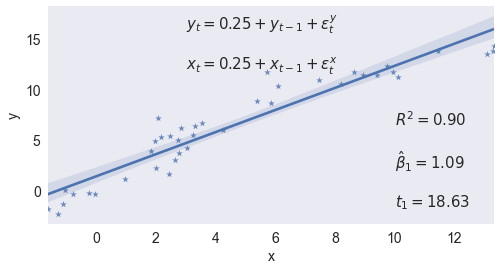

In [11]:
fig, ax = plt.subplots(figsize=[8,4])
sns.regplot(x=x,y=y,marker='*',ax=ax)
ax.set(xlabel='x', ylabel='y')

statslabel = f'$R^2={res.rsquared:.2f}$'
statslabel += f'\n\n$\\hat\\beta_1={res.params[1]:.2f}$'
statslabel += f'\n\n$t_1={res.tvalues[1]:.2f}$'
ax.annotate(statslabel, (10,8), size=15, va='top')

modellabel = r'$y_t = 0.25 + y_{t-1} + \epsilon^y_t$'
modellabel += '\n\n$x_t = 0.25 + x_{t-1} + \\epsilon^x_t$'
ax.annotate(modellabel, (3,17.5), size=15, va='top')

ax.grid(False)
fig.savefig(figpath+'regresion-espuria-1caso.pdf', bbox_inches='tight')

In [12]:
res.params

array([1.44456189, 1.08570021])

In [13]:
np.linalg.solve(X.T @ X, X.T @ y)

array([1.44456189, 1.08570021])

## Experimento de Monte Carlo para determinar la distribución del estadítico t

In [14]:
N = 100_000

def Monte_Carlo(funcion, repeticiones=N, *args, **kwargs):
    datos = Parallel(n_jobs=-1)(delayed(funcion)(*args, **kwargs) for _ in range(repeticiones))
    return pd.Series(datos)

### Regresión con datos estacionarios

In [15]:
def regresion_estacionaria(T=100):
    y, x = np.random.randn(2,T)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [16]:
%%time
np.random.seed(12345)
tvalues = Monte_Carlo(regresion_estacionaria)

Wall time: 11.4 s


### Regresión con caminatas aleatorias

In [17]:
def regresion_espuria(T=100):
    e = np.random.randn(2,T)
    y, x = e.cumsum(axis=1)
    X = sm.add_constant(x)
    res = sm.OLS(y, X).fit()
    return res.tvalues[1]

In [18]:
%%time
np.random.seed(12345)
zvalues = Monte_Carlo(regresion_espuria)

Wall time: 8.58 s


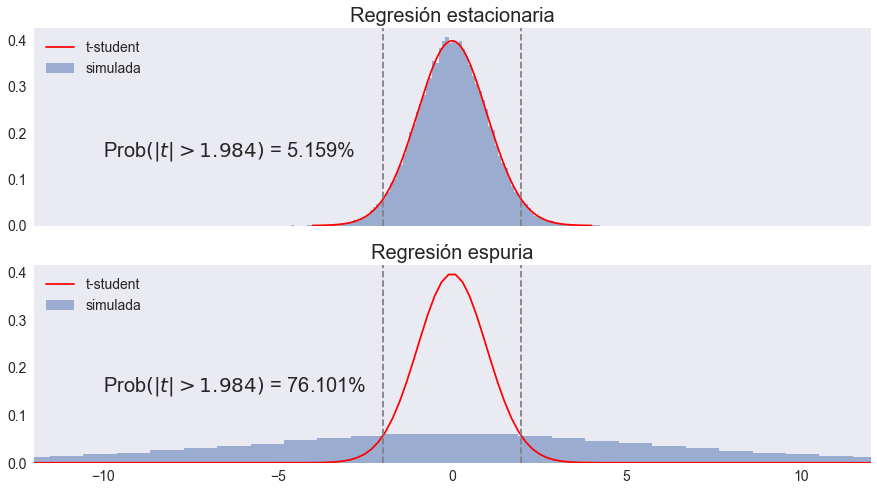

In [19]:
fig, (ax0,ax1) = plt.subplots(2,1,figsize=[15, 8], sharex=True)

maxtval = 12
t5crit = t_Student.isf(0.05/2, 98)


# regresión estacionaria
ff, edges = np.histogram(tvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax0.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-4,4, 200)
ax0.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax0.set(xlim=[-maxtval, maxtval], title='Regresión estacionaria')
ax0.legend(['t-student', 'simulada'], loc='upper left')


# regresión espuria
ff, edges = np.histogram(zvalues, bins=100, density=True)
center = (edges[1:] + edges[:-1])/2
w = center[1] - center[0]

ax1.bar(center, ff, width=w, alpha=0.5)
xvals = np.linspace(-20, 20, 200)
ax1.plot(xvals, t_Student.pdf(xvals, df=98), '-r')
ax1.set(xlim=[-maxtval,maxtval], title='Regresión espuria')
ax1.legend(['t-student', 'simulada'], loc='upper left')

# valores críticos
opciones = dict(ls="--", color='gray')
ax0.axvline(t5crit, **opciones)
ax0.axvline(-t5crit, **opciones)
ax1.axvline(t5crit, **opciones)
ax1.axvline(-t5crit, **opciones)

# error tipo I
err1 = (tvalues.abs() > t5crit).mean()*100
ax0.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1:.3f}%', (-10,0.15), size=20)

err1bad = (zvalues.abs() > t5crit).mean()*100
ax1.annotate(f'Prob$\\left(|t| > 1.984\\right)$ = {err1bad:.3f}%', (-10,0.15), size=20)

ax0.grid(False)
ax1.grid(False)
fig.savefig(figpath + 'regresion-espuria.pdf', bbox_inches='tight')